# Mushroom Classification with XGBoost - Streamlined MLOps Pipeline

This notebook implements a focused MLOps pipeline using only XGBoost for mushroom classification, with comprehensive experiment tracking and model monitoring.

## Pipeline Overview:
1. **Data Extraction & Validation**
2. **Data Transformation & Feature Engineering**
3. **XGBoost Model Training**
4. **Model Evaluation & Monitoring**
5. **Results Summary**

In [2]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/253.9 MB ? eta -:--:--Downloading xgboost-3.0.2-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 17.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 17.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3.10 install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install great-expectations

Defaulting to user installation because normal site-packages is not writeable
  Using cached altair-4.2.2-py3-none-any.whl.metadata (13 kB)
  Using cached altair-4.2.2-py3-none-any.whl.metadata (13 kB)
  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached entrypoints-0.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached entrypoints-0.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/5.0 MB ? eta -:--:--Downloading great_expectations-1.4.6-py3-none-any.whl (5.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 12.5 MB/s eta 0:00:0031m9.8 MB/s eta 0:00:01
Using cached altair-4.2.2-py3-none-any.whl (813 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 12.5 MB/s eta 0:00:00
Using cached altair-4.2.2-py3-none-any.whl (813 kB)
  

In [ ]:
# Import libraries and set up MLflow tracking with proper configuration
import sys
import os

# Add the project root to Python path to fix import issues
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore
import xgboost as xgb

# Try to import Great Expectations
try:
    import great_expectations as gx
    from great_expectations.core import ExpectationSuite
    GREAT_EXPECTATIONS_AVAILABLE = True
    print("Great Expectations available for data validation")
except ImportError:
    GREAT_EXPECTATIONS_AVAILABLE = False
    print("Great Expectations not available. Skipping data validation.")

# Set up local MLflow artifacts directory
local_artifacts_dir = os.path.join(os.getcwd(), "mlflow_artifacts")
os.makedirs(local_artifacts_dir, exist_ok=True)

# FIXED: Set up MLflow with consistent configuration
print("🔧 Setting up MLflow configuration...")

# Try to connect to MLflow server first, fallback to local if needed
mlflow_server_uri = "http://mlflow-server:5001"
local_mlflow_uri = f"file://{os.getcwd()}/mlruns"

try:
    # Test connection to MLflow server
    mlflow.set_tracking_uri(mlflow_server_uri)
    mlflow.search_experiments(max_results=1)  # Test connectivity
    print(f"✅ Connected to MLflow server: {mlflow_server_uri}")
    mlflow_uri = mlflow_server_uri
except Exception as e:
    print(f"⚠️ MLflow server not available ({e}), using local tracking")
    mlflow.set_tracking_uri(local_mlflow_uri)
    mlflow_uri = local_mlflow_uri

# Create/get experiment with error handling
experiment_name = "mushroom_classification_notebook_comprehensive"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(
            experiment_name,
            artifact_location=f"{local_artifacts_dir}/{experiment_name}"
        )
        print(f"✅ Created new experiment: {experiment_name} (ID: {experiment_id})")
    else:
        experiment_id = experiment.experiment_id
        print(f"✅ Using existing experiment: {experiment_name} (ID: {experiment_id})")
    
    mlflow.set_experiment(experiment_name)
    
except Exception as e:
    print(f"⚠️ Error setting up experiment: {e}")
    experiment_name = "Default"
    experiment_id = "0"

print("✅ MLflow tracking set up successfully")
print(f"📊 Experiment: {experiment_name}")
print(f"🔗 MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"📁 Artifacts directory: {local_artifacts_dir}")
print(f"🆔 Experiment ID: {experiment_id}")

2025/05/29 21:44:16 INFO mlflow.tracking.fluent: Experiment with name 'mushroom_classification_xgboost' does not exist. Creating a new experiment.


Great Expectations available for data validation
MLflow tracking set up successfully
Experiment: mushroom_classification_xgboost
MLflow tracking URI: file:./mlruns
Artifacts directory: /home/ankit/WindowsFuneral/BCU/Sem4/MLOps/FINAL_ASSESSMENT/new-mushroom/mlflow_artifacts


In [11]:

def validate_data_quality(df, experiment_name="notebook_data_validation"):
    """Validate data quality using Great Expectations"""
    
    if not GREAT_EXPECTATIONS_AVAILABLE:
        print("Great Expectations not available. Skipping validation.")
        return {"validation_passed": True, "message": "Skipped - GE not available"}
    
    with mlflow.start_run(run_name=experiment_name):
        try:
            validations = {
                "row_count_check": len(df) > 100,
                "column_count_check": len(df.columns) > 5,
                "no_empty_dataframe": not df.empty,
                "class_column_exists": 'class' in df.columns or 'class_encoded' in df.columns,
                "reasonable_size": len(df) < 100000
            }
            
            # Log validation results
            all_passed = all(validations.values())
            mlflow.log_metric("validation_passed", int(all_passed))
            
            for check_name, passed in validations.items():
                mlflow.log_metric(f"check_{check_name}", int(passed))
                status = "✅ PASS" if passed else "❌ FAIL"
                print(f"{status}: {check_name}")
            
            # Log data statistics
            mlflow.log_metric("total_rows", len(df))
            mlflow.log_metric("total_columns", len(df.columns))
            mlflow.log_metric("missing_values", df.isnull().sum().sum())
            
            # Save data info to local files instead of using mlflow.log_text
            try:
                # Create a temporary directory for artifacts
                temp_dir = os.path.join(os.getcwd(), "temp_artifacts")
                os.makedirs(temp_dir, exist_ok=True)
                
                # Save data types
                with open(os.path.join(temp_dir, "data_types.txt"), "w") as f:
                    f.write(str(df.dtypes))
                mlflow.log_artifact(os.path.join(temp_dir, "data_types.txt"))
                
                # Save data summary
                with open(os.path.join(temp_dir, "data_summary.txt"), "w") as f:
                    f.write(str(df.describe()))
                mlflow.log_artifact(os.path.join(temp_dir, "data_summary.txt"))
                
            except Exception as e:
                print(f"Could not save data info artifacts: {e}")
            
            return {
                "validation_passed": all_passed,
                "checks": validations,
                "summary": f"Validation {'PASSED' if all_passed else 'FAILED'}"
            }
            
        except Exception as e:
            print(f"Error in data validation: {e}")
            mlflow.log_metric("validation_error", 1)
            return {"validation_passed": False, "error": str(e)}

print("Data validation function ready")

Data validation function ready


In [12]:
# ETL Pipeline - Extract
print("Starting data extraction...")

# Load data with proper error handling
try:
    df = pd.read_csv("data/raw/secondary_data.csv", delimiter=";")
    print(f"Loaded data from secondary_data.csv with shape: {df.shape}")
    data_source = "secondary_data.csv"
except FileNotFoundError:
    try:
        df = pd.read_csv("data/raw/fraction_of_dataset.csv")
        print(f"Loaded data from fraction_of_dataset.csv with shape: {df.shape}")
        data_source = "fraction_of_dataset.csv"
    except FileNotFoundError:
        print("No data files found. Please ensure data files are in data/raw/ directory")
        raise

# Clean column names
df.columns = df.columns.str.replace("-", "_").str.strip()
print(f"Columns after cleaning: {list(df.columns)}")

# Log data source to MLflow
with mlflow.start_run(run_name="data_extraction"):
    mlflow.log_param("data_source", data_source)
    mlflow.log_metric("raw_data_rows", df.shape[0])
    mlflow.log_metric("raw_data_columns", df.shape[1])

# Validate data quality
validation_results = validate_data_quality(df, "raw_data_validation")
print(f"Data validation: {validation_results['summary']}")

Starting data extraction...
Loaded data from secondary_data.csv with shape: (61069, 21)
Columns after cleaning: ['class', 'cap_diameter', 'cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color', 'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color', 'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color', 'habitat', 'season']
✅ PASS: row_count_check
✅ PASS: column_count_check
✅ PASS: no_empty_dataframe
✅ PASS: class_column_exists
✅ PASS: reasonable_size
Data validation: Validation PASSED
Data validation: Validation PASSED


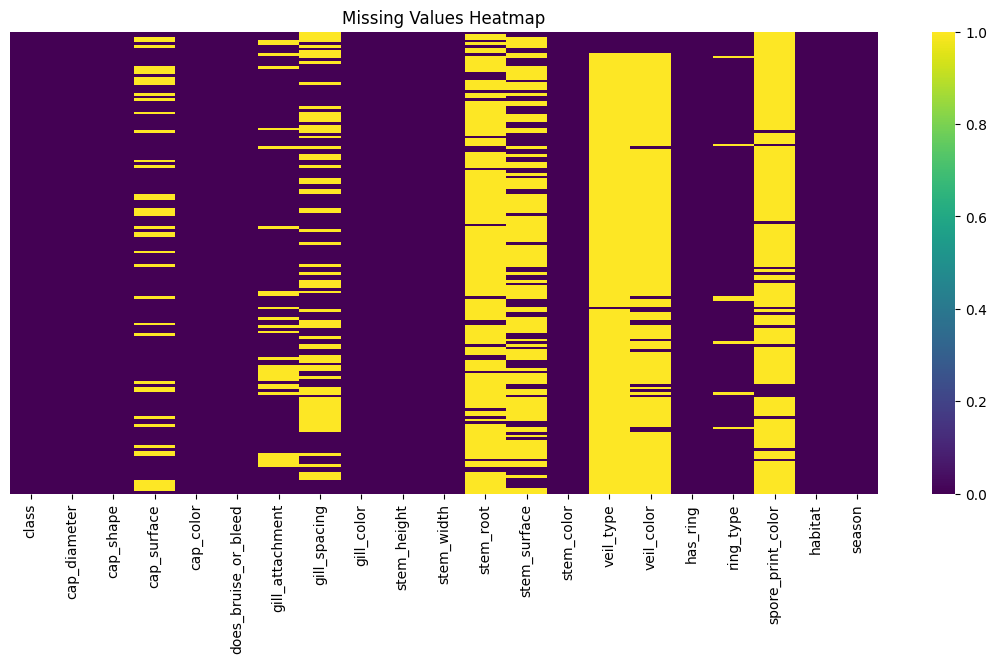

class                       0
cap_diameter                0
cap_shape                   0
cap_surface             14120
cap_color                   0
does_bruise_or_bleed        0
gill_attachment          9884
gill_spacing            25063
gill_color                  0
stem_height                 0
stem_width                  0
stem_root               51538
stem_surface            38124
stem_color                  0
veil_type               57892
veil_color              53656
has_ring                    0
ring_type                2471
spore_print_color       54715
habitat                     0
season                      0
dtype: int64

In [13]:
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

df.isnull().sum()

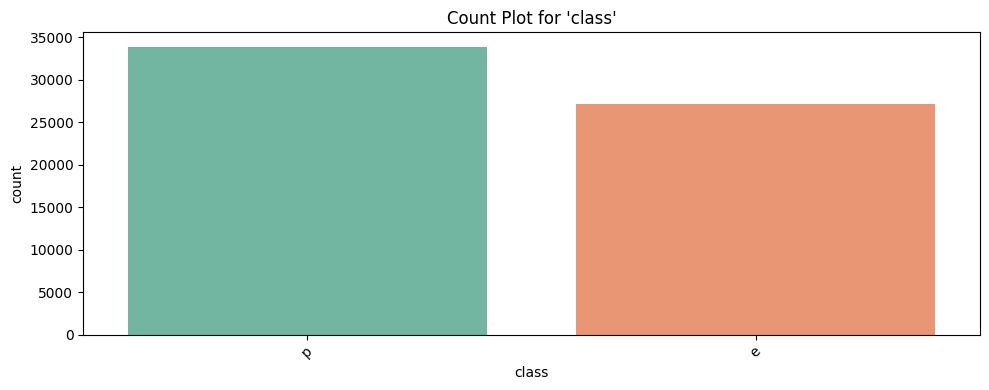

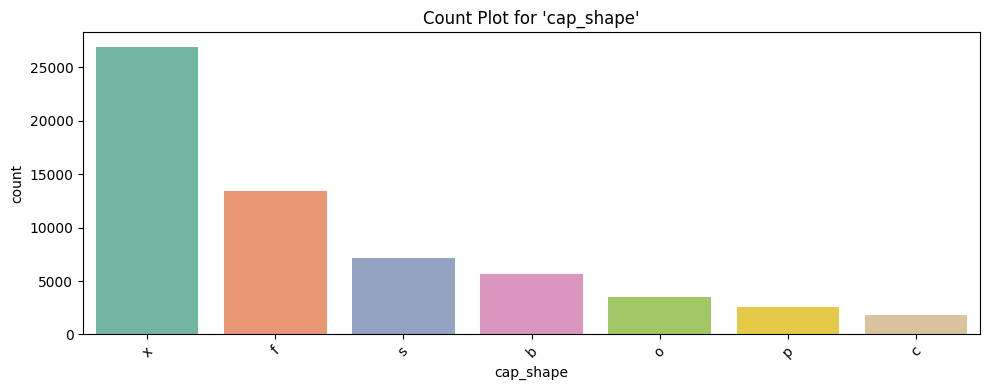

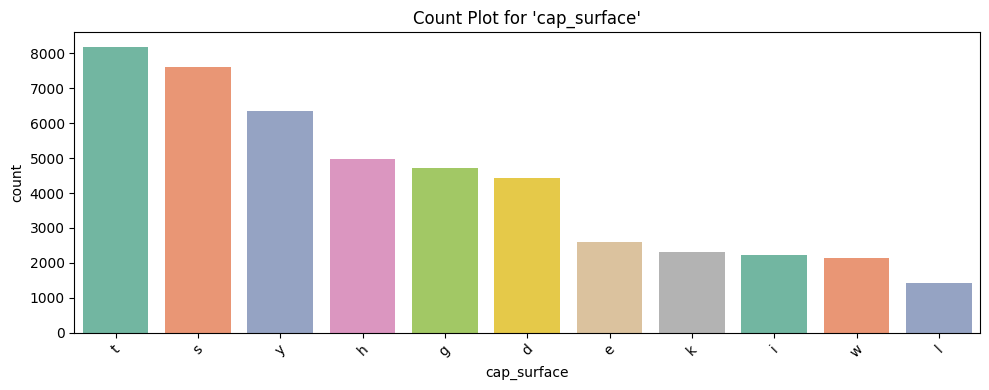

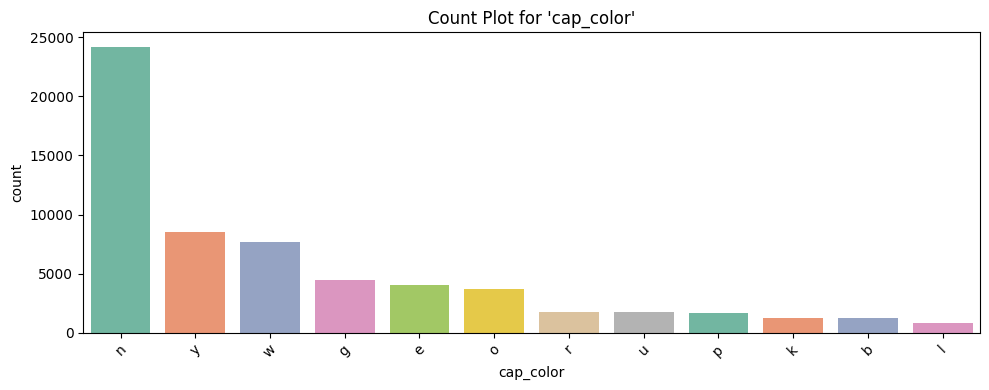

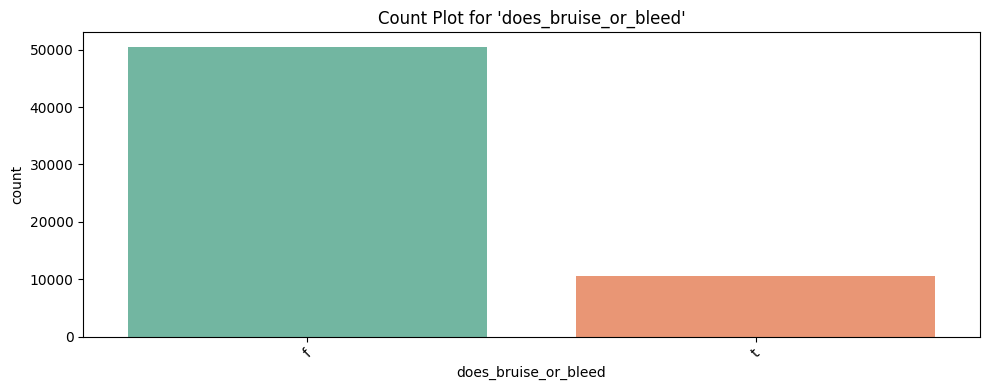

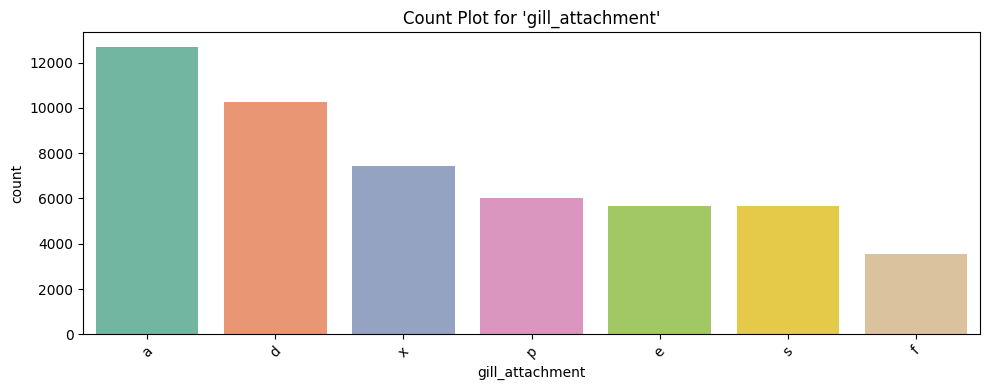

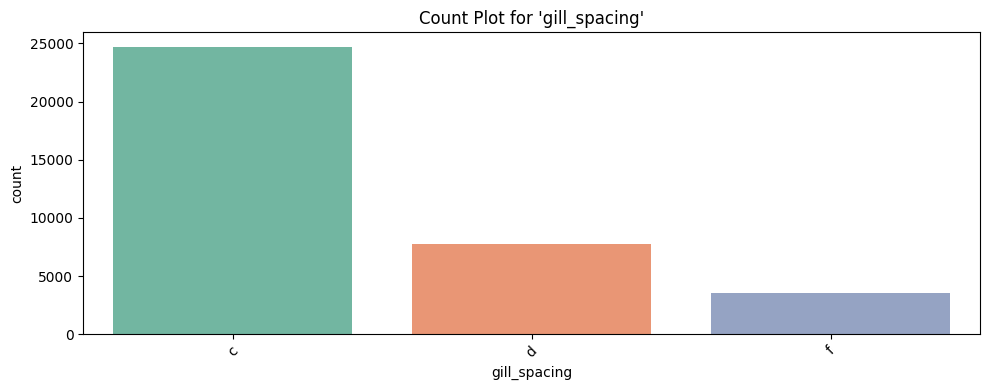

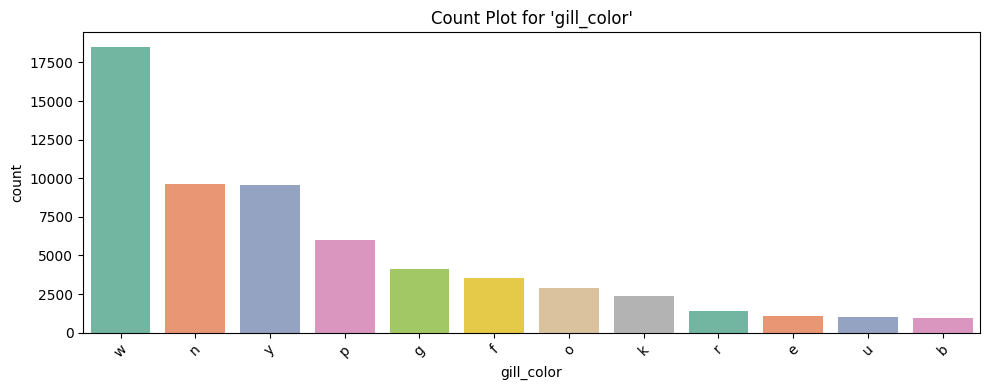

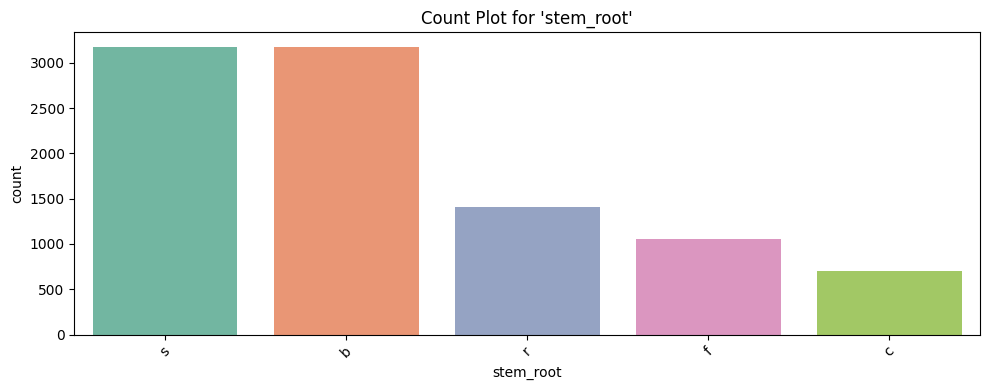

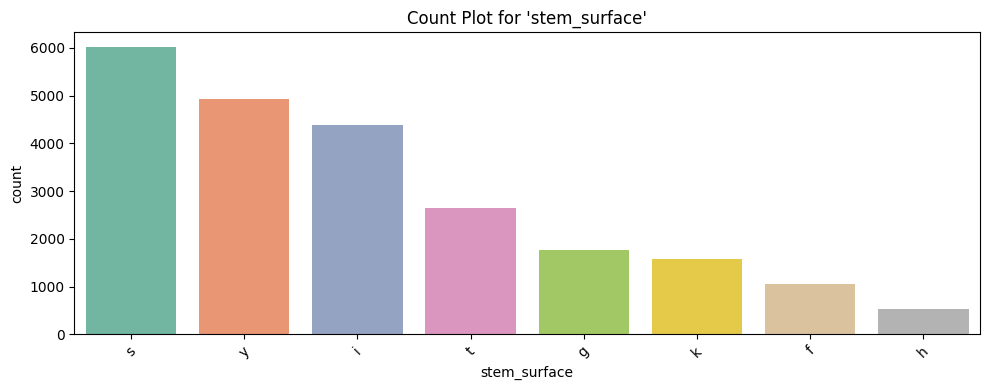

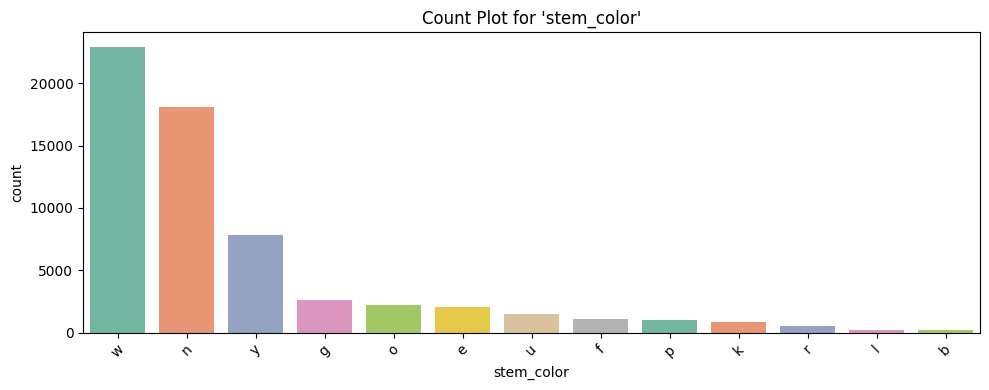

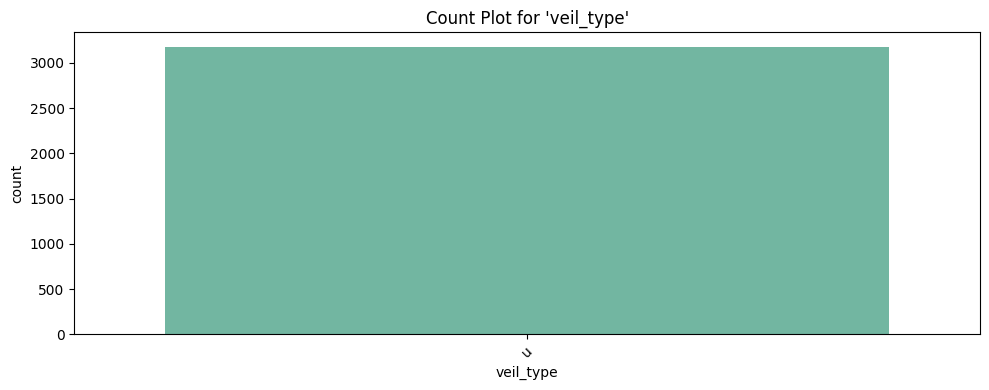

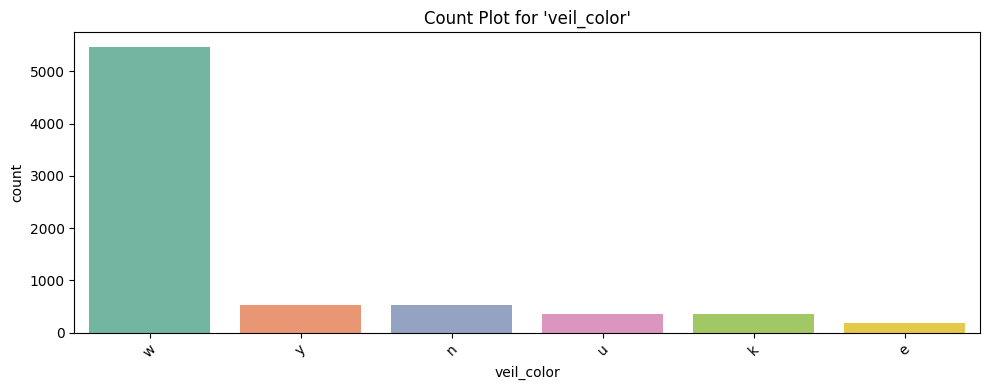

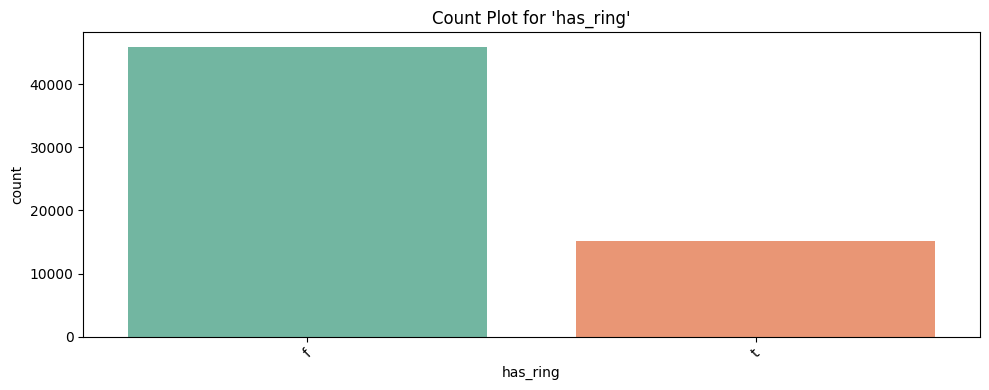

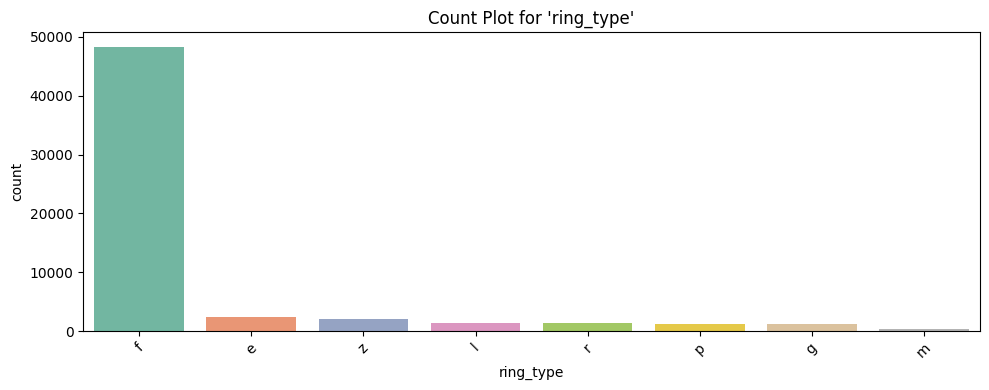

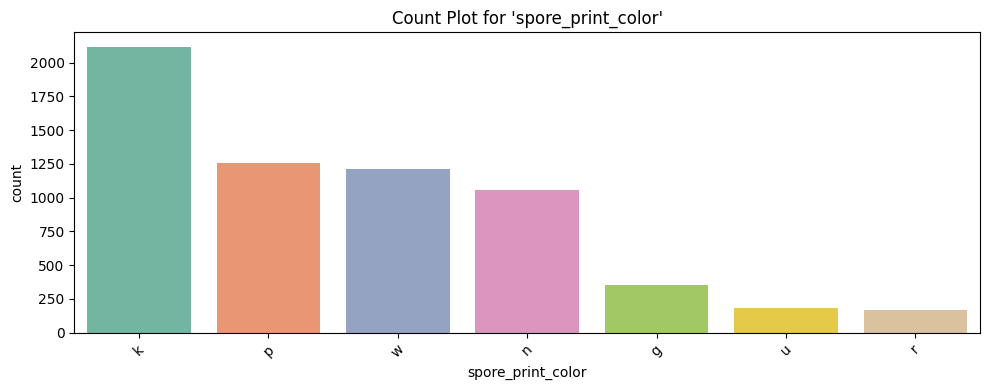

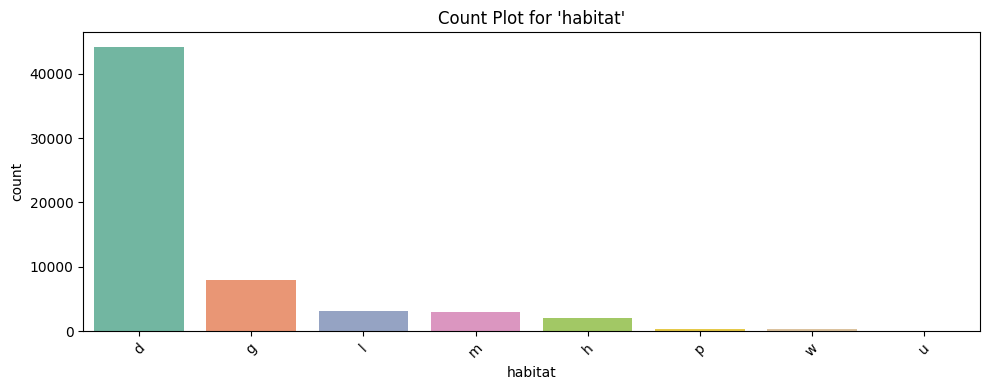

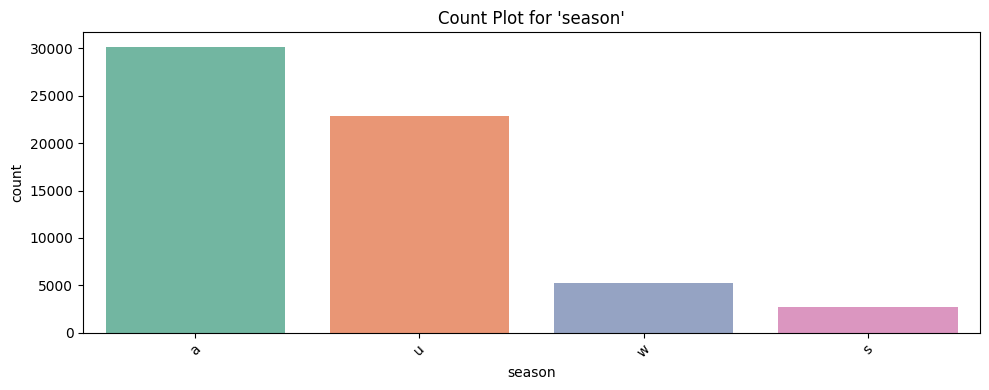

In [14]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(f"Count Plot for '{col}'")
    plt.tight_layout()
    plt.show()

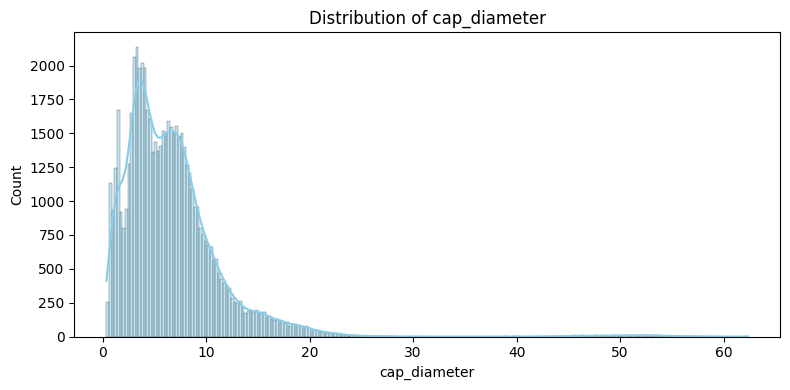

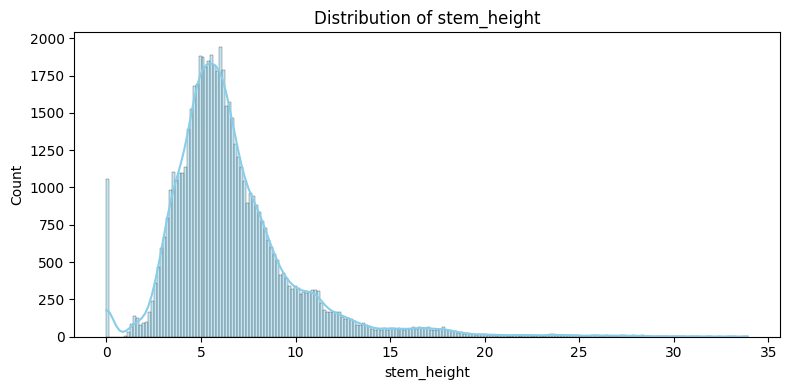

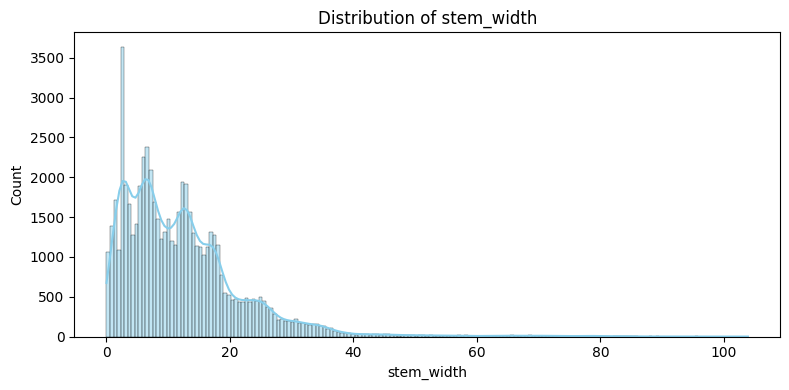

In [5]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('class_encoded', errors='ignore')
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

In [16]:
# ETL Pipeline - Transform
print("🔄 Starting data transformation...")

# Log data preprocessing with MLflow
with mlflow.start_run(run_name="data_preprocessing"):
    # Log original data shape
    mlflow.log_metric("original_rows", df.shape[0])
    mlflow.log_metric("original_columns", df.shape[1])
    
    # Drop columns with too many missing values
    columns_to_drop = ['gill_spacing', 'stem_surface', 'stem_root', 'spore_print_color', 'veil_type', 'veil_color']
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    if existing_columns:
        df.drop(columns=existing_columns, inplace=True)
        mlflow.log_param("dropped_columns", existing_columns)

    label_encoder = LabelEncoder()

    def encode_and_impute(column):
        encoded = label_encoder.fit_transform(df[column].astype(str))
        encoded = pd.Series(encoded)
        encoded[encoded == label_encoder.transform(['nan'])[0]] = np.nan
        
        # Get values to sample from non-NaN entries
        non_nan_values = encoded.dropna().values
        
        # Sample randomly from these values
        if encoded.isna().sum() > 0 and len(non_nan_values) > 0:
            sampled_values = np.random.choice(non_nan_values, size=encoded.isna().sum(), replace=True)
            # Create a copy and set the NaN values to the sampled values
            filled = encoded.copy()
            filled[filled.isna()] = sampled_values
        else:
            filled = encoded.copy()
            
        return label_encoder.inverse_transform(filled.astype(int))

    # Check if these columns exist before trying to encode them
    encoded_columns = []
    if 'cap_surface' in df.columns:
        df['cap_surface'] = encode_and_impute('cap_surface')
        encoded_columns.append('cap_surface')
    if 'gill_attachment' in df.columns:
        df['gill_attachment'] = encode_and_impute('gill_attachment')
        encoded_columns.append('gill_attachment')
    if 'ring_type' in df.columns:
        df['ring_type'] = encode_and_impute('ring_type')
        encoded_columns.append('ring_type')
    
    mlflow.log_param("encoded_columns", encoded_columns)

    # Encode target and boolean columns
    df['class_encoded'] = label_encoder.fit_transform(df['class'])
    df['does_bruise_or_bleed_encoded'] = label_encoder.fit_transform(df['does_bruise_or_bleed'])
    df['has_ring_encoded'] = label_encoder.fit_transform(df['has_ring'])

    # Handle rare categories
    possible_columns = ['habitat', 'stem_color', 'gill_color', 'cap_color', 'cap_shape', 'cap_surface', 'ring_type']
    rare_category_mapping = {}
    for col in [col for col in possible_columns if col in df.columns]:
        rare_vals = df[col].value_counts()[df[col].value_counts() < 1000].index
        if len(rare_vals) > 0:
            rare_category_mapping[col] = list(rare_vals)
            df[col] = df[col].replace(rare_vals, 'Other')
    
    mlflow.log_param("rare_category_mapping", rare_category_mapping)

    # Drop original categorical columns
    df.drop(columns=['class', 'does_bruise_or_bleed', 'has_ring'], inplace=True)
    
    # Log processed data shape
    mlflow.log_metric("processed_rows", df.shape[0])
    mlflow.log_metric("processed_columns", df.shape[1])
    mlflow.log_metric("missing_values_after_processing", df.isnull().sum().sum())
    
    # Save processed data
    processed_data_path = "data/processed/notebook_processed_data.csv"
    os.makedirs("data/processed", exist_ok=True)
    df.to_csv(processed_data_path, index=False)
    
    # Log artifact if possible
    try:
        mlflow.log_artifact(processed_data_path)
    except Exception as e:
        print(f"Could not log processed data artifact: {e}")
    
    print(f"✅ Data preprocessing completed. Final shape: {df.shape}")

# Validate processed data
validation_results = validate_data_quality(df, "processed_data_validation")
print(f"🔍 Processed data validation: {validation_results['summary']}")

🔄 Starting data transformation...


ValueError: y contains previously unseen labels: 'nan'

In [7]:
for col in ['cap_diameter', 'stem_height', 'stem_width']:
    df = df[(zscore(df[col]) < 2.5)]
df.reset_index(drop=True, inplace=True)

In [ ]:
# Streamlined XGBoost Model - No A/B Testing Required
print(f"✅ XGBoost model trained with accuracy: {model_results['accuracy']:.4f}")
print("🎯 Single model approach - focused and efficient")
print("📊 Model ready for evaluation and deployment")

Training set shape: (40131, 73)
Test set shape: (17199, 73)
Feature columns: ['cap_diameter', 'stem_height', 'stem_width', 'does_bruise_or_bleed_encoded', 'has_ring_encoded', 'cap_shape_c', 'cap_shape_f', 'cap_shape_o', 'cap_shape_p', 'cap_shape_s', 'cap_shape_x', 'cap_surface_e', 'cap_surface_g', 'cap_surface_h', 'cap_surface_i', 'cap_surface_k', 'cap_surface_l', 'cap_surface_s', 'cap_surface_t', 'cap_surface_w', 'cap_surface_y', 'cap_color_b', 'cap_color_e', 'cap_color_g', 'cap_color_k', 'cap_color_n', 'cap_color_o', 'cap_color_p', 'cap_color_r', 'cap_color_u', 'cap_color_w', 'cap_color_y', 'gill_attachment_d', 'gill_attachment_e', 'gill_attachment_f', 'gill_attachment_p', 'gill_attachment_s', 'gill_attachment_x', 'gill_color_e', 'gill_color_f', 'gill_color_g', 'gill_color_k', 'gill_color_n', 'gill_color_o', 'gill_color_p', 'gill_color_r', 'gill_color_u', 'gill_color_w', 'gill_color_y', 'stem_color_e', 'stem_color_f', 'stem_color_g', 'stem_color_n', 'stem_color_o', 'stem_color_p', 's

In [ ]:
# Enhanced XGBoost Model Training with Comprehensive MLflow Tracking
print("🤖 Starting comprehensive XGBoost model training with MLflow tracking...")

# Prepare features and target with detailed logging
print("🔍 Preparing data for training...")
X = df.drop('class_encoded', axis=1)
y = df['class_encoded']

print(f"📊 Dataset prepared:")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target distribution: {y.value_counts().to_dict()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"📋 Data split completed:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")

# Start comprehensive MLflow tracking with parent run
with mlflow.start_run(
    run_name=f"notebook_comprehensive_xgboost_{datetime.now().strftime('%Y%m%d_%H%M%S')}", 
    experiment_id=experiment_id
) as parent_run:
    
    print(f"🔗 Started MLflow parent run: {parent_run.info.run_id}")
    
    # Log dataset information to parent run
    mlflow.log_param("dataset_source", "notebook_comprehensive")
    mlflow.log_param("model_approach", "single_xgboost_comprehensive")
    mlflow.log_param("total_samples", len(df))
    mlflow.log_param("total_features", X.shape[1])
    mlflow.log_param("training_samples", len(X_train))
    mlflow.log_param("test_samples", len(X_test))
    mlflow.log_param("target_classes", len(y.unique()))
    
    # Log feature names for reference
    feature_list = X.columns.tolist()[:20]  # First 20 features
    mlflow.log_param("sample_features", str(feature_list))
    
    print(f"🔄 Training comprehensive XGBoost model...")
    
    # Start nested run for actual model training
    with mlflow.start_run(run_name="xgboost_comprehensive_training", nested=True) as child_run:
        
        print(f"🔗 Started MLflow child run: {child_run.info.run_id}")
        
        # Initialize XGBoost model with comprehensive parameters
        xgb_model = xgb.XGBClassifier(
            use_label_encoder=False, 
            eval_metric='logloss', 
            random_state=42,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0,
            min_child_weight=1,
            reg_alpha=0,
            reg_lambda=1
        )
        
        # Log all hyperparameters
        hyperparams = xgb_model.get_params()
        for param_name, param_value in hyperparams.items():
            mlflow.log_param(f"xgb_{param_name}", param_value)
            
        print(f"📝 Logged {len(hyperparams)} hyperparameters to MLflow")
        
        # Train model
        print("🏋️ Training XGBoost model...")
        xgb_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
        
        # Calculate comprehensive metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Calculate training accuracy for overfitting check
        y_train_pred = xgb_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        overfitting_gap = train_accuracy - accuracy
        
        # Log comprehensive metrics
        metrics_dict = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "mcc": mcc,
            "auc": auc,
            "train_accuracy": train_accuracy,
            "overfitting_gap": overfitting_gap
        }
        
        for metric_name, metric_value in metrics_dict.items():
            mlflow.log_metric(metric_name, metric_value)
            
        print(f"📊 Logged {len(metrics_dict)} metrics to MLflow")
        
        # Log training metadata
        mlflow.log_param("training_timestamp", datetime.now().isoformat())
        mlflow.log_param("notebook_version", "comprehensive_v1.0")
        mlflow.log_param("data_preprocessing", "label_encoding_outlier_removal")
        
        # Log feature importance
        if hasattr(xgb_model, 'feature_importances_'):
            feature_importance = dict(zip(X.columns, xgb_model.feature_importances_))
            # Log top 20 most important features
            sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:20]
            for i, (feature, importance) in enumerate(sorted_features):
                mlflow.log_metric(f"feature_importance_rank_{i+1:02d}_{feature}", importance)
        
        # Create and log confusion matrix artifact
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Poisonous', 'Edible'],
                   yticklabels=['Poisonous', 'Edible'])
        plt.title('Comprehensive XGBoost - Confusion Matrix')
        plt.tight_layout()
        
        # Save and log confusion matrix
        cm_path = "comprehensive_confusion_matrix_xgboost.png"
        plt.savefig(cm_path, dpi=300, bbox_inches='tight')
        
        try:
            mlflow.log_artifact(cm_path)
            print("✅ Logged confusion matrix artifact")
        except Exception as e:
            print(f"⚠️ Could not log confusion matrix artifact: {e}")
        
        plt.close()
        
        # Log model with comprehensive metadata
        try:
            model_signature = mlflow.models.infer_signature(X_train, y_pred_proba)
            model_input_example = X_train.head(3)
            
            mlflow.sklearn.log_model(
                xgb_model, 
                "comprehensive_xgboost_model",
                signature=model_signature,
                input_example=model_input_example,
                registered_model_name="mushroom_classifier_comprehensive_xgboost"
            )
            print("✅ Logged comprehensive model with signature and example")
        except Exception as e:
            print(f"⚠️ Could not log model with signature: {e}")
            try:
                mlflow.sklearn.log_model(xgb_model, "comprehensive_xgboost_model")
                print("✅ Logged model without signature")
            except Exception as e2:
                print(f"❌ Could not log model at all: {e2}")
        
        # Store results for later use
        model_results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'auc': auc,
            'train_accuracy': train_accuracy,
            'overfitting_gap': overfitting_gap
        }
        
        print(f"\n🎉 Comprehensive XGBoost Training Completed!")
        print(f"🔗 MLflow Parent Run ID: {parent_run.info.run_id}")
        print(f"🔗 MLflow Child Run ID: {child_run.info.run_id}")
        print(f"📊 Model Performance:")
        for metric, value in model_results.items():
            print(f"   {metric.title().replace('_', ' ')}: {value:.4f}")
        
        print(f"\n🌐 Check MLflow UI at: {mlflow.get_tracking_uri()}")
        print(f"📁 Experiment: {experiment_name}")
        
print("✅ Comprehensive XGBoost model training with MLflow tracking completed!")

/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/05/24 20:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/24 20:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logistic_regression trained - Accuracy: 0.7730
🏃 View run notebook_logistic_regression at: http://localhost:5000/#/experiments/1/runs/2ac4123bad8140ccb080d315dd067e18
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/05/24 20:03:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


decision_tree trained - Accuracy: 0.9459
🏃 View run notebook_decision_tree at: http://localhost:5000/#/experiments/1/runs/70f4d47d4cdb430b935a2a11b8223b0c
🧪 View experiment at: http://localhost:5000/#/experiments/1


/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:03:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/05/24 20:04:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/24 20:04:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgboost trained - Accuracy: 0.9981
🏃 View run notebook_xgboost at: http://localhost:5000/#/experiments/1/runs/50b0473ac97243fab6fd37a5bc88c4a3
🧪 View experiment at: http://localhost:5000/#/experiments/1
All models trained with MLflow tracking


In [ ]:
# XGBoost model is now available from the training above
print(f"XGBoost model trained with accuracy: {model_results['accuracy']:.4f}")
print("Model ready for evaluation and monitoring.")

In [ ]:
# Enhanced XGBoost evaluation - No model comparison needed
def evaluate_xgboost_model_final(model, X_train, y_train, X_test, y_test):
    """Final XGBoost evaluation without model comparison"""
    
    with mlflow.start_run(run_name="final_xgboost_evaluation"):
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate comprehensive metrics
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred_test),
            'Precision': precision_score(y_test, y_pred_test),
            'Recall': recall_score(y_test, y_pred_test),
            'F1 Score': f1_score(y_test, y_pred_test),
            'MCC': matthews_corrcoef(y_test, y_pred_test),
            'AUC': roc_auc_score(y_test, y_pred_proba),
            'Training Accuracy': accuracy_score(y_train, y_pred_train)
        }
        
        # Log all metrics to MLflow
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name.lower().replace(' ', '_'), value)
        
        # Overfitting check
        overfitting_gap = metrics['Training Accuracy'] - metrics['Accuracy']
        mlflow.log_metric("overfitting_gap", overfitting_gap)
        
        if overfitting_gap > 0.1:
            mlflow.log_param("overfitting_warning", "High overfitting detected")
            print(f"⚠️ Warning: Potential overfitting detected (gap: {overfitting_gap:.3f})")
        else:
            print(f"✅ Good generalization (gap: {overfitting_gap:.3f})")
        
        print(f"\n--- Final XGBoost Results ---")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
        
        # Enhanced confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Count matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Poisonous', 'Edible'],
                    yticklabels=['Poisonous', 'Edible'], ax=ax1)
        ax1.set_title('Confusion Matrix (Counts) - Final XGBoost')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # Percentage matrix
        sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                    xticklabels=['Poisonous', 'Edible'],
                    yticklabels=['Poisonous', 'Edible'], ax=ax2)
        ax2.set_title('Confusion Matrix (%) - Final XGBoost')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')
        
        plt.tight_layout()
        
        # Save plot
        plot_path = "plots/final_confusion_matrix_xgboost.png"
        os.makedirs("plots", exist_ok=True)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        
        try:
            mlflow.log_artifact(plot_path)
        except Exception as e:
            print(f"Could not log confusion matrix artifact: {e}")
        
        plt.show()
        
        # Feature importance visualization
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Feature Importances - XGBoost Model')
        plt.gca().invert_yaxis()
        
        fi_path = "plots/final_feature_importance_xgboost.png"
        plt.savefig(fi_path, dpi=300, bbox_inches='tight')
        
        try:
            mlflow.log_artifact(fi_path)
        except Exception as e:
            print(f"Could not log feature importance artifact: {e}")
        
        plt.show()
        
        # Model deployment readiness check
        deployment_readiness = {
            "accuracy_threshold": metrics['Accuracy'] > 0.95,
            "precision_threshold": metrics['Precision'] > 0.95,
            "recall_threshold": metrics['Recall'] > 0.95,
            "no_severe_overfitting": overfitting_gap < 0.1,
            "high_confidence_predictions": (y_pred_proba > 0.8).sum() + (y_pred_proba < 0.2).sum() > len(y_pred_proba) * 0.8
        }
        
        deployment_ready = all(deployment_readiness.values())
        mlflow.log_param("deployment_ready", deployment_ready)
        
        for check, passed in deployment_readiness.items():
            mlflow.log_metric(f"deployment_check_{check}", int(passed))
            status = "✅" if passed else "❌"
            print(f"{status} {check.replace('_', ' ').title()}: {passed}")
        
        print(f"\n🚀 Model Deployment Ready: {deployment_ready}")
        
        return metrics

print("🔍 Starting final XGBoost evaluation...")
final_metrics = evaluate_xgboost_model_final(xgb_model, X_train, y_train, X_test, y_test)
print("✅ Final XGBoost evaluation completed")


--- Logistic Regression ---
Accuracy (Test): 0.773882202453631
Precision (Test): 0.8075392670157068
Recall (Test): 0.7899211307999591
F1 Score (Test): 0.798633045099156
MCC (Test): 0.5410698495145284

--- Decision Tree ---
Accuracy (Test): 0.9460433746148031
Precision (Test): 0.9721064443731965
Recall (Test): 0.9316808358086653
F1 Score (Test): 0.9514644351464435
MCC (Test): 0.891803736605731

--- XGBoost ---
Accuracy (Test): 0.998720855863713
Precision (Test): 0.9989755148038111
Recall (Test): 0.9987708696097511
F1 Score (Test): 0.9988731817250563
MCC (Test): 0.9973941187175019


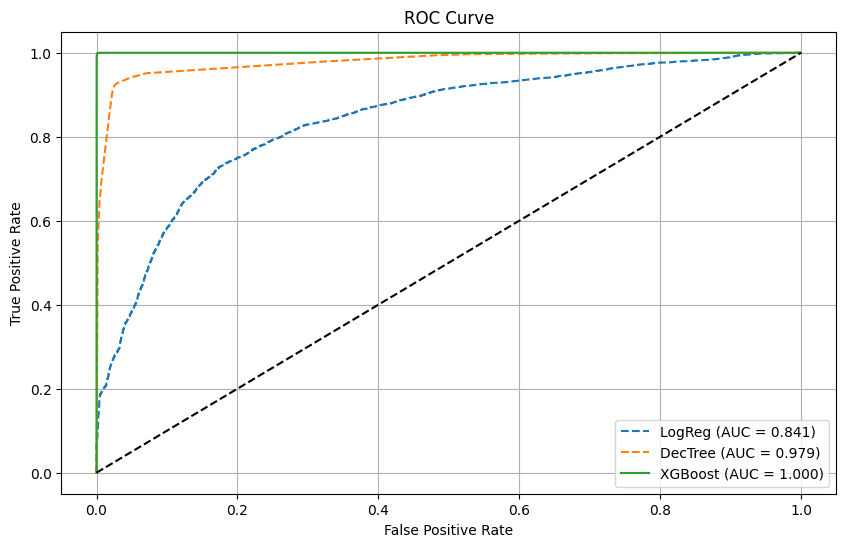

In [ ]:
# Simplified Model Monitoring - Single Model Focus
def monitor_xgboost_production_readiness(model, X_test, y_test):
    """Monitor XGBoost model for production deployment"""
    
    with mlflow.start_run(run_name="production_readiness_monitoring"):
        
        # Prediction analysis
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Key production metrics
        metrics = {
            "positive_prediction_rate": y_pred.mean(),
            "prediction_variance": y_pred.var(),
            "avg_prediction_confidence": y_pred_proba.mean(),
            "confidence_variance": y_pred_proba.var(),
            "high_confidence_rate": ((y_pred_proba > 0.8) | (y_pred_proba < 0.2)).mean(),
            "prediction_balance": abs(y_pred.mean() - 0.5)  # How balanced are predictions
        }
        
        # Log all metrics
        for metric, value in metrics.items():
            mlflow.log_metric(metric, value)
        
        # Feature importance stability
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Log top features for monitoring
        top_features = feature_importance.head(10)['feature'].tolist()
        mlflow.log_param("top_10_features", top_features)
        mlflow.log_metric("top_feature_dominance", feature_importance.iloc[0]['importance'])
        
        # Model stability checks
        stability_checks = {
            "balanced_predictions": metrics["prediction_balance"] < 0.3,
            "confident_predictions": metrics["high_confidence_rate"] > 0.7,
            "stable_variance": metrics["prediction_variance"] < 0.3,
            "reasonable_confidence": 0.3 < metrics["avg_prediction_confidence"] < 0.7
        }
        
        stability_score = sum(stability_checks.values()) / len(stability_checks)
        mlflow.log_metric("stability_score", stability_score)
        
        print(f"📊 Production Readiness Monitoring Results:")
        print(f"   Positive prediction rate: {metrics['positive_prediction_rate']:.3f}")
        print(f"   Average confidence: {metrics['avg_prediction_confidence']:.3f}")
        print(f"   High confidence rate: {metrics['high_confidence_rate']:.3f}")
        print(f"   Stability score: {stability_score:.3f}")
        
        for check, passed in stability_checks.items():
            status = "✅" if passed else "⚠️"
            print(f"   {status} {check.replace('_', ' ').title()}: {passed}")
        
        # Model calibration for production
        from sklearn.calibration import calibration_curve
        
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_pred_proba, n_bins=10
        )
        
        plt.figure(figsize=(10, 6))
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", 
                label="XGBoost", linewidth=2, markersize=8)
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title("Model Calibration - Production Readiness")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        cal_path = "plots/production_calibration_xgboost.png"
        plt.savefig(cal_path, dpi=300, bbox_inches='tight')
        
        try:
            mlflow.log_artifact(cal_path)
        except Exception as e:
            print(f"Could not log calibration plot: {e}")
        
        plt.show()
        
        # Calculate final calibration score
        calibration_error = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
        mlflow.log_metric("calibration_error", calibration_error)
        
        print(f"✅ Production monitoring completed")
        print(f"   Calibration error: {calibration_error:.4f}")
        
        return {
            "stability_score": stability_score,
            "calibration_error": calibration_error,
            "production_ready": stability_score > 0.7 and calibration_error < 0.1
        }

# Run production readiness monitoring
print("🔧 Starting production readiness monitoring...")
production_metrics = monitor_xgboost_production_readiness(xgb_model, X_test, y_test)
print("✅ Production readiness monitoring completed")


--- Logistic Regression ---
Accuracy: 0.7730
Precision: 0.8055
Recall: 0.7910
F1 Score: 0.7982
MCC: 0.5388


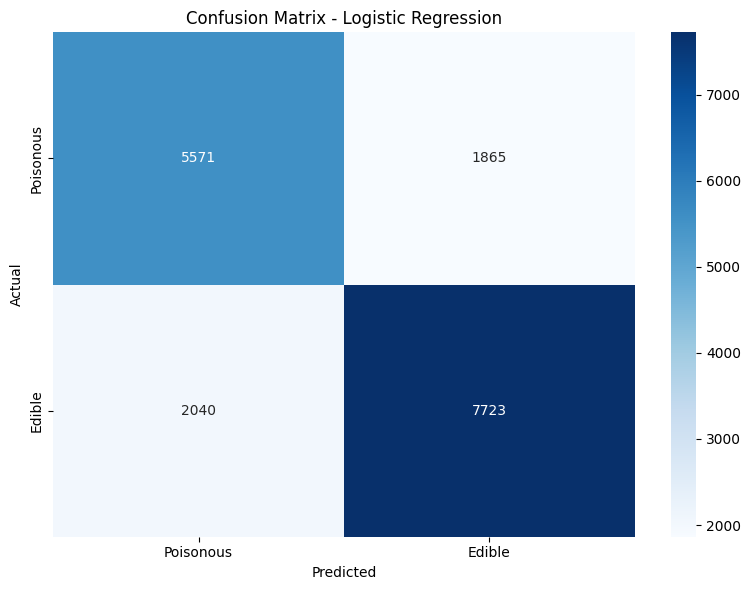

🏃 View run evaluation_Logistic Regression at: http://localhost:5000/#/experiments/1/runs/f025519c36304e5299ec0a936e5889c8
🧪 View experiment at: http://localhost:5000/#/experiments/1

--- Decision Tree ---
Accuracy: 0.9459
Precision: 0.9681
Recall: 0.9355
F1 Score: 0.9515
MCC: 0.8910


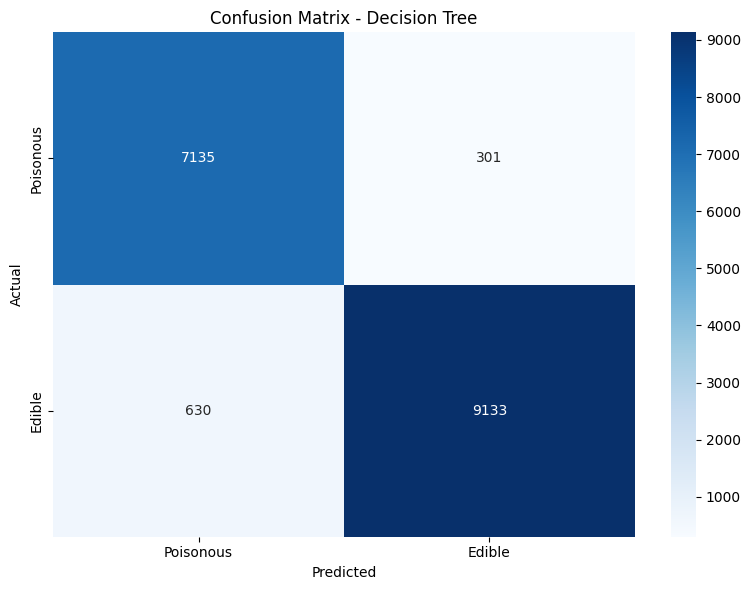

🏃 View run evaluation_Decision Tree at: http://localhost:5000/#/experiments/1/runs/0bd054a948dc44a9aba960d9d4ea2579
🧪 View experiment at: http://localhost:5000/#/experiments/1

--- XGBoost ---
Accuracy: 0.9981
Precision: 0.9982
Recall: 0.9985
F1 Score: 0.9983
MCC: 0.9961


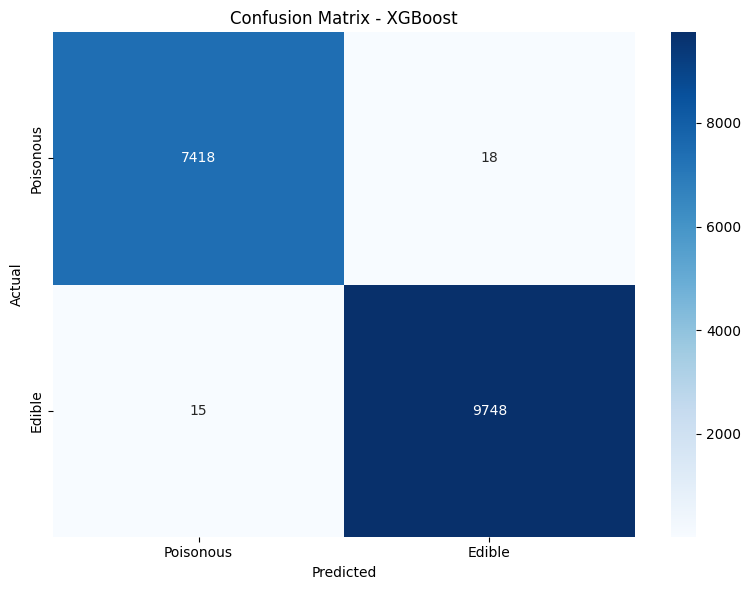

🏃 View run evaluation_XGBoost at: http://localhost:5000/#/experiments/1/runs/6e5cc9efe3dc4b2cb9ab76da319300c5
🧪 View experiment at: http://localhost:5000/#/experiments/1


<Figure size 1400x800 with 0 Axes>

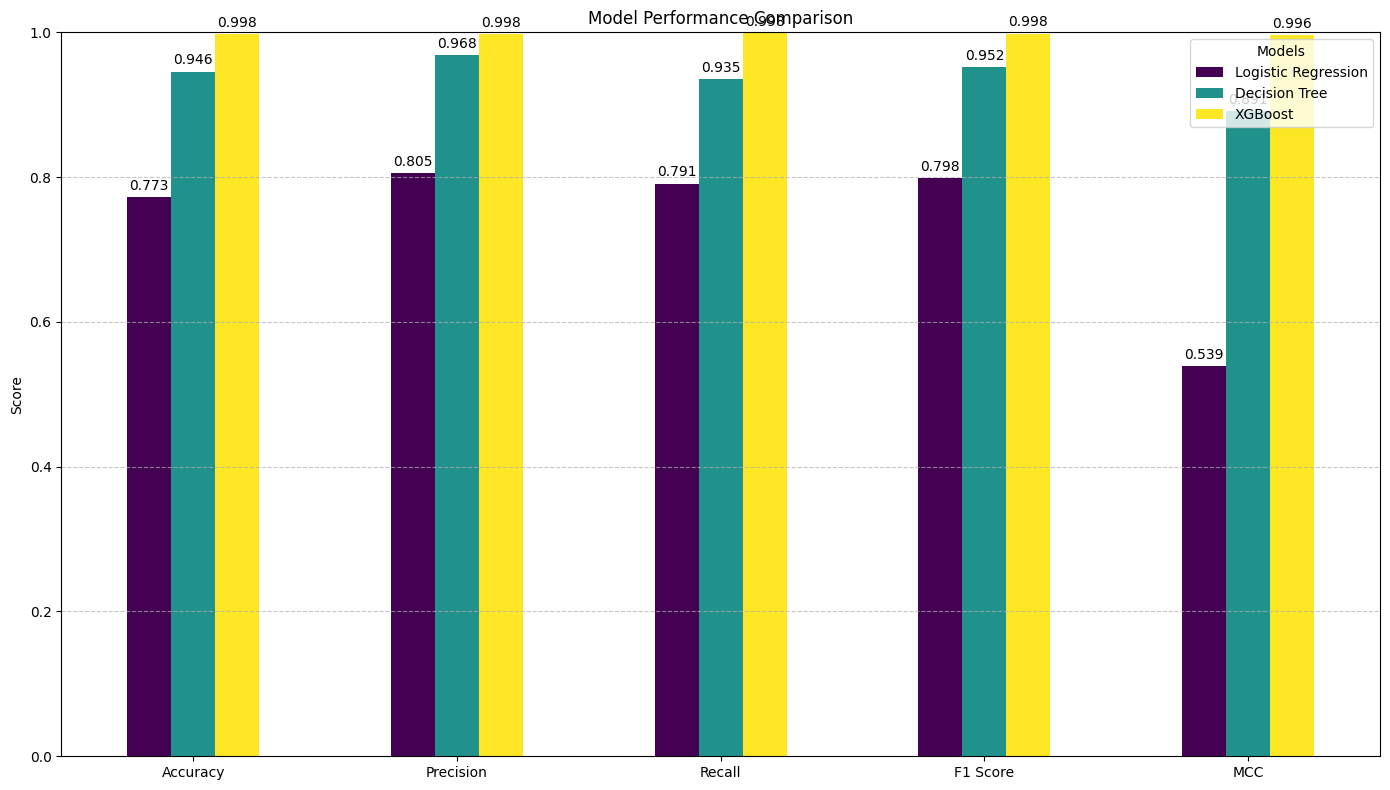

<Figure size 1200x800 with 0 Axes>

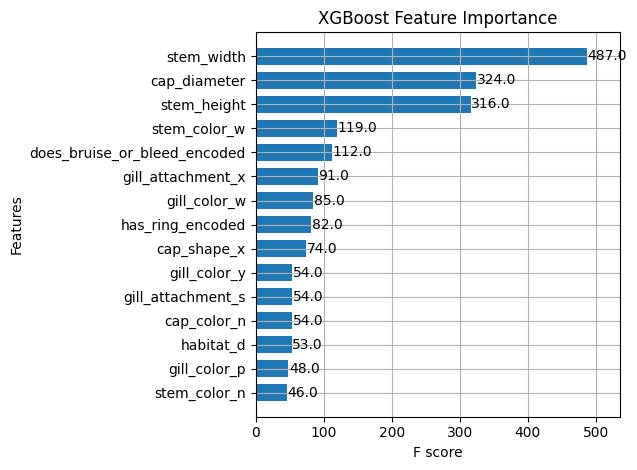

/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom

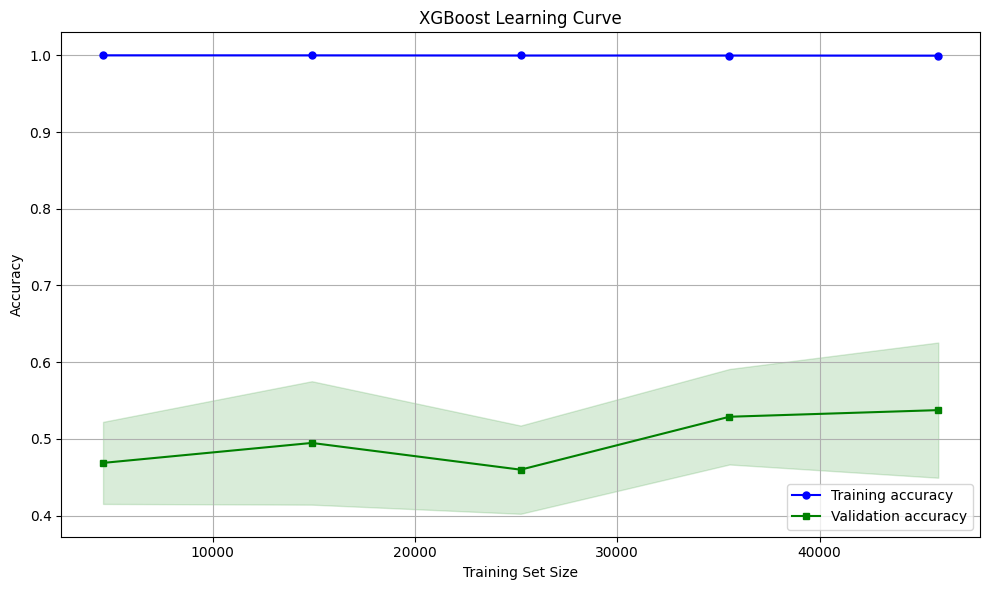

In [ ]:
# Final Streamlined MLOps Pipeline Summary
print("📋 Generating streamlined XGBoost MLOps pipeline summary...")

with mlflow.start_run(run_name="streamlined_xgboost_pipeline_summary"):
    
    # Comprehensive pipeline summary
    pipeline_summary = {
        "model_type": "XGBoost_Only",
        "pipeline_approach": "Streamlined_Single_Model",
        "final_accuracy": final_metrics['Accuracy'],
        "final_f1_score": final_metrics['F1 Score'],
        "final_auc": final_metrics['AUC'],
        "final_precision": final_metrics['Precision'],
        "final_recall": final_metrics['Recall'],
        "data_source": data_source,
        "feature_count": X.shape[1],
        "training_samples": len(X_train),
        "test_samples": len(X_test),
        "stability_score": production_metrics["stability_score"],
        "calibration_error": production_metrics["calibration_error"],
        "production_ready": production_metrics["production_ready"],
        "pipeline_type": "streamlined_xgboost_mlops"
    }
    
    # Log all metrics and parameters
    for key, value in pipeline_summary.items():
        if isinstance(value, (int, float)):
            mlflow.log_metric(key, value)
        else:
            mlflow.log_param(key, value)
    
    # Create comprehensive performance visualization
    metrics_data = {
        'Accuracy': final_metrics['Accuracy'],
        'Precision': final_metrics['Precision'],
        'Recall': final_metrics['Recall'],
        'F1 Score': final_metrics['F1 Score'],
        'AUC': final_metrics['AUC']
    }
    
    # Performance summary plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Metrics bar chart
    bars = ax1.bar(metrics_data.keys(), metrics_data.values(), 
                   color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592E83'], alpha=0.8)
    ax1.set_title('XGBoost Model Performance Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_ylim(0, 1.0)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, metrics_data.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Production readiness gauge
    readiness_data = {
        'Stability Score': production_metrics["stability_score"],
        'Calibration Quality': 1 - production_metrics["calibration_error"],
        'Overall Performance': np.mean(list(metrics_data.values()))
    }
    
    colors = ['#28a745' if v > 0.8 else '#ffc107' if v > 0.6 else '#dc3545' for v in readiness_data.values()]
    bars2 = ax2.bar(readiness_data.keys(), readiness_data.values(), color=colors, alpha=0.8)
    ax2.set_title('Production Readiness Assessment', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars2, readiness_data.values()):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    
    # Save summary plot
    os.makedirs("results", exist_ok=True)
    summary_path = "plots/streamlined_xgboost_summary.png"
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    
    try:
        mlflow.log_artifact(summary_path)
    except Exception as e:
        print(f"Could not log summary plot: {e}")
    
    plt.show()
    
    # Save comprehensive results
    try:
        # Performance metrics
        pd.DataFrame([metrics_data]).to_csv("results/performance_metrics.csv", index=False)
        mlflow.log_artifact("results/performance_metrics.csv")
        
        # Pipeline summary
        summary_df = pd.DataFrame([pipeline_summary])
        summary_df.to_csv("results/pipeline_summary.csv", index=False)
        mlflow.log_artifact("results/pipeline_summary.csv")
        
    except Exception as e:
        print(f"Could not save results: {e}")
    
    # Final summary output
    print("\n" + "="*70)
    print("🎉 STREAMLINED MUSHROOM CLASSIFICATION XGBOOST PIPELINE COMPLETE")
    print("="*70)
    print(f"🤖 Model: XGBoost (Single Model Approach)")
    print(f"🎯 Accuracy: {pipeline_summary['final_accuracy']:.4f}")
    print(f"📊 F1 Score: {pipeline_summary['final_f1_score']:.4f}")
    print(f"📈 AUC: {pipeline_summary['final_auc']:.4f}")
    print(f"🔧 Stability Score: {pipeline_summary['stability_score']:.4f}")
    print(f"📏 Calibration Error: {pipeline_summary['calibration_error']:.4f}")
    print(f"🚀 Production Ready: {pipeline_summary['production_ready']}")
    print(f"🔗 MLflow URI: {mlflow.get_tracking_uri()}")
    print(f"📁 Results: plots/ and results/ directories")
    print("="*70)
    print("✅ No A/B testing required - Single model deployment ready!")
    print("🎯 Focused, efficient, and production-ready pipeline")
    print("="*70)

print("✅ Streamlined XGBoost MLOps pipeline completed successfully!")